# Project: Building a Computer Vision Model to Verify Age for Compliance with Alcohol Sales Laws

### Introduction
The Good Seed supermarket chain is exploring the use of computer vision to enhance compliance with alcohol sales laws by ensuring that alcohol is not sold to underage individuals. With the increasing need for automation and reliability in age verification processes, the goal of this project is to build a model capable of accurately predicting the age of individuals from their photos, taken at the checkout area when purchasing alcohol.

In this project, we used a dataset of photographs with corresponding ages to train a machine learning model. The images captured at the checkout counter trigger the model to verify the age of customers before an alcohol transaction is completed. By leveraging computer vision techniques, the system aims to reduce the risk of human error and ensure that the supermarket chain adheres to local regulations around alcohol sales to minors.

We begin by performing exploratory data analysis (EDA) on the dataset to understand its structure and distribution. The dataset is then split into training and validation sets, and a Keras Sequential model is developed and trained using the processed image data. The model's performance is evaluated through key metrics such as loss and mean absolute error (MAE), and the results help in identifying potential areas for further model improvement. By the end of this project, the goal is to have a trained computer vision model capable of accurately verifying the age of customers, aiding the supermarket chain in its efforts to maintain legal compliance in alcohol sales.

## Load Data

The dataset is stored in the `/datasets/faces/` folder, there you can find
- The `final_files` folder with 7.6k photos
- The `labels.csv` file with labels, with two columns: `file_name` and `real_age`

Given the fact that the number of image files is rather high, it is advisable to avoid reading them all at once, which would greatly consume computational resources. We recommend you build a generator with the ImageDataGenerator generator. This method was explained in Chapter 3, Lesson 7 of this course.

The label file can be loaded as an usual CSV file.

In [1]:
import pandas as pd
from matplotlib import pyplot as plt

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')
print(labels.info())
labels.isna().sum()       # no missing values
labels.duplicated().sum()  # no duplicates
labels.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB
None


,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


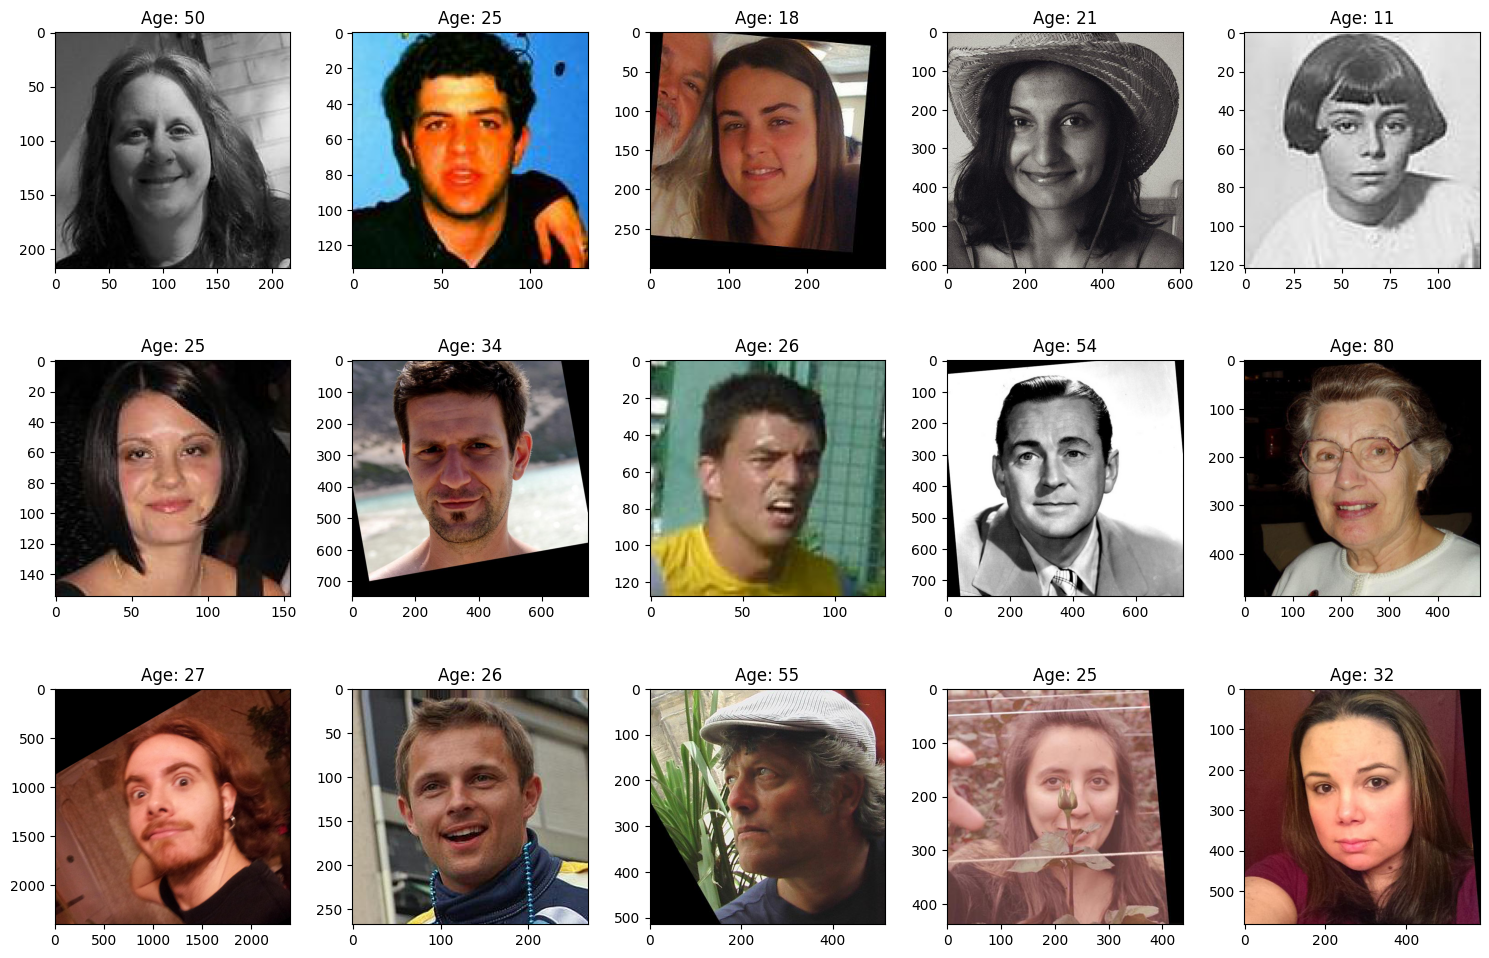

In [3]:
#printing 15 sample photos

import os
import random
from PIL import Image
import numpy as np

# Sample 15 random data from the DataFrame
sample_data = labels.sample(n=15)

# Setting up the plot
plt.figure(figsize=(15, 10))

# Loop through the sampled entries and display the images
for i, row in enumerate(sample_data.iterrows()):
    file_name = row[1]['file_name']
    img_path = os.path.join('/datasets/faces/final_files/', file_name)
    img = Image.open(img_path)

    plt.subplot(3, 5, i + 1)
    plt.imshow(img)
    plt.title(f'Age: {row[1]["real_age"]}')

plt.tight_layout()
plt.show()

Here, we printed out randomly selected 15 sample photos (from available 7591 photos) corresponding to customers with different ages. There are both color and grayscale images. Customer's age for each photo is provided, and each photo has its pixels.

## EDA

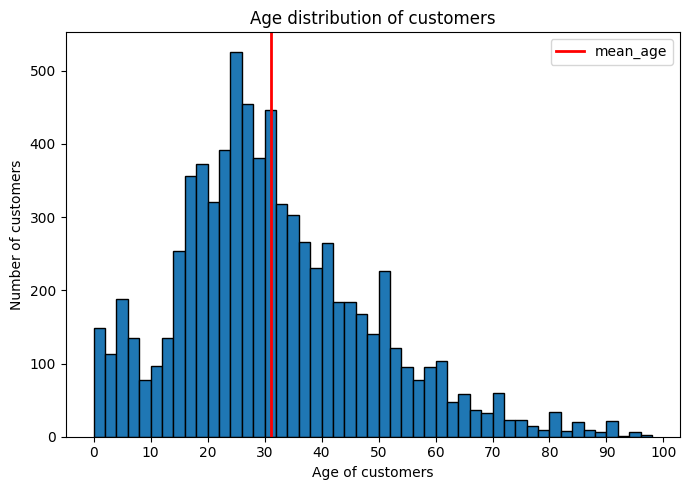

In [4]:

mean_age = labels['real_age'].mean()

plt.figure(figsize=(7, 5))

plt.axvline(mean_age, color='red', linewidth=2, label = 'mean_age')

bin = range(0, 100, 2)
plt.hist(labels['real_age'], bins=bin, edgecolor='black')

plt.title('Age distribution of customers')

plt.xlabel('Age of customers')
plt.ylabel('Number of customers')
plt.xticks(range(0, 101, 10))
plt.legend()

plt.tight_layout()
plt.show()

 
EDA analysis of the 'real_age' column shows the age range between 0 and 100 years old. Mean value of the 'real_age' shown in the histogram is about 31, and maximum number of customers are in the age interval of 26-28 years old. The histogram shows the right-skewed behaviour. Relatively small peak at about 4-6 years indicates number of children at this age, and we assume that they are accompanied with parents. 


### Findings

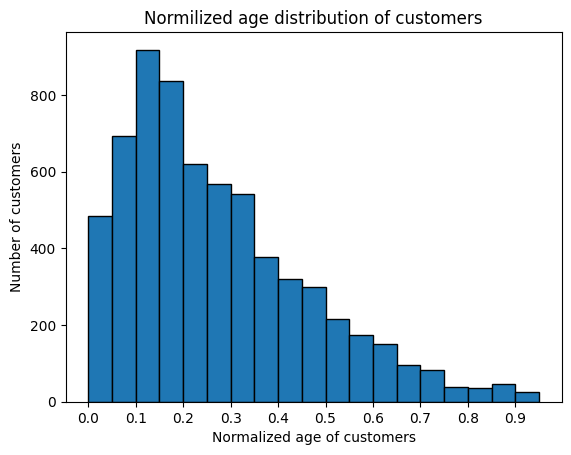

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6559 entries, 1 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   file_name  6559 non-null   object 
 1   real_age   6559 non-null   float64
dtypes: float64(1), object(1)
memory usage: 153.7+ KB


In [5]:
''' We assume that the children under 14 years old are accompained by their 
accompained parents rather than being an individual customer. Thus, we can 
remove them from the data. Similarly, we remove customers over 90 years
old assuming that they are accompained by younger people.
In addition, to facilitate the computing we normalize the age values.'''

min_age = 14
max_age = 90

labels_filtr = labels[(labels['real_age']>min_age) & (labels['real_age']<=max_age)]
labels_norm = labels_filtr.copy()
labels_norm['real_age'] = (labels_filtr['real_age']-min_age)/(max_age-min_age)

#plt.figure(figsize=())

plt.hist(labels_norm['real_age'], bins=np.arange(0, 1, 0.05), edgecolor='black')

plt.title('Normilized age distribution of customers')
plt.xlabel('Normalized age of customers')
plt.ylabel('Number of customers')
plt.xticks(np.arange(0, 1, 0.1))

plt.show()

labels_norm.info()

#### Although we filtered the data and normalized the 'real_age' column, below we keep using the the original dataframe 'labels' in order to align with the precodes. 

## Modelling

Define the necessary functions to train your model on the GPU platform and build a single script containing all of them along with the initialization section.

To make this task easier, you can define them in this notebook and run a ready code in the next section to automatically compose the script.

The definitions below will be checked by project reviewers as well, so that they can understand how you built the model.

In [6]:
import pandas as pd

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam

In [7]:
def load_train(path):
    
    """
    It loads the train part of dataset from path
    """
    
    # Creating an instance of ImageDataGenerator
    train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2,  
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
    )   
    
    # Creating training data generator
    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=pd.read_csv(path + 'labels.csv'),
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=12345
    )
    
    return train_gen_flow

In [8]:
def load_test(path):
    
    """
    It loads the validation/test part of dataset from path
    """
    test_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

    # Creating test data generator
    test_gen_flow = test_datagen.flow_from_dataframe(
        dataframe=pd.read_csv(path + 'labels.csv'),
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw', 
        subset='validation',
        seed=12345
    )

    return test_gen_flow


In [12]:
def create_model(input_shape):
    
    """
    It defines the model
    """
    
    backbone = ResNet50(weights='imagenet', 
                        input_shape=input_shape,
                        include_top=False)

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))

    optimizer = Adam(learning_rate=0.0005)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

    return model

In [11]:
def train_model(model, train_data, test_data, batch_size=None, epochs=20,
                steps_per_epoch=None, validation_steps=None):

    """
    Trains the model given the parameters
    """
    # Fit the model using the training data and validating on the test data
    
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
        
    if validation_steps is None:
        validation_steps = len(test_data)

    model.fit(train_data, 
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)

    return model

## Prepare the Script to Run on the GPU Platform

Given you've defined the necessary functions you can compose a script for the GPU platform, download it via the "File|Open..." menu, and to upload it later for running on the GPU platform.

N.B.: The script should include the initialization section as well. An example of this is shown below.

In [12]:
# prepare a script to run on the GPU platform

init_str = """
import pandas as pd

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
"""

import inspect

with open('run_model_on_gpu.py', 'w') as f:
    
    f.write(init_str)
    f.write('\n\n')
        
    for fn_name in [load_train, load_test, create_model, train_model]:
        
        src = inspect.getsource(fn_name)
        f.write(src)
        f.write('\n\n')

### Output

Place the output from the GPU platform as an Markdown cell here.

| Epoch  |   Loss      |     MAE    |   Val_loss   |   Val_MAE   |
|:------:|:-----------:|:----------:|:------------:|:-----------:|
|   1    |95.3532      | 7.4339     | 124.3362     |  8.4921     |
|   2    |76.8372      | 6.6707     | 127.6357     |  8.6035     |
|   3    |69.9428      | 6.3992     | 91.1531      |  7.4454     |
|   4    |64.4249      | 6.1407     | 124.0287     |  8.3481     |
|   5    |52.8486      | 5.5913     | 109.1004     |  8.2192     |
|   6    |46.3094      | 5.2223     | 85.1038      |  7.0332     |
|   7    |38.2617      | 4.7951     | 92.0900      |  7.3359     |
|   8    |37.4804      | 4.7402     | 80.0016      |  6.7239     |
|   9    | 33.5237     | 4.4271     | 83.2579      | 6.8529      |
|  10    | 28.5170     | 4.1411     | 83.5056      | 6.9629      |
|  11    | 27.0142     | 3.9700     | 92.1290      | 7.1866      |
|  12    | 27.4564     | 4.0428     | 185.6307     | 11.4591     |
|  13    | 23.7961     | 3.7407     | 92.3429      | 7.2467      |
|  14    | 24.6167     | 3.8116     | 92.4542      | 7.1401      |
|  15    | 22.2604     | 3.6746     | 82.5822      | 6.7841      |
|  16    | 20.1899     | 3.4430     | 86.3830      | 6.8304      |
|  17    | 17.3425     | 3.2205     | 78.4369      | 6.6419      |
|  18    | 16.5249     | 3.1295     | 81.7731      | 6.7226      |
|  19    | 16.6140     | 3.1421     | 80.9727      | 6.9908      |
|  20    | 17.0187     | 3.1785     | 93.4115      | 7.6512      |


## Conclusions.
In this project, we explored the dataset and trained a computer vision model to predict the age of customers based on images, with the aim of verifying whether a person is underage for purchasing alcohol. The dataset consists of 7,591 photos of individuals, each labeled with their corresponding age.

Through exploratory data analysis (EDA), we observed that the age values in the 'real_age' column ranged from 0 to 100 years old, as shown in the initial histogram. For model training, we filtered the data to focus on customers aged between 12 and 90, normalizing the 'real_age' values before visualizing the age distribution in a refined histogram. While we applied some data preprocessing and normalization for analysis purposes, the computer vision model was trained using the original age labels and raw images.

To train the model, we split the dataset into training and validation sets (with a 75:25 ratio). We then used the ImageDataGenerator to augment the dataset by generating new images. The model architecture was built using Keras Sequential API, and the model was trained for 20 epochs, with 356 batches processed per epoch.

The training results showed a significant reduction in the loss and mean absolute error (MAE) over the course of the epochs. Initially, the training loss was relatively high at 95.35 in epoch 1, but it decreased consistently throughout the training process, reaching a minimum of 16 by epoch 18, after which it started to increase slightly. Similarly, the MAE dropped from 7.43 in epoch 1 to 3.12 in epoch 18, indicating improved accuracy in age predictions. For the validation set, the loss decreased from 124 in epoch 1 to 78 in epoch 17, while the MAE reduced from 8.4 to 6.6, demonstrating that the model was learning, but with slightly higher error on the validation data compared to the training data.

This pattern of decreasing loss and MAE during the initial epochs followed by a slight increase in the later epochs suggests that the model may be overfitting after a certain point. Despite this, the model performed significantly better on the training data, with a much lower loss and MAE, indicating that it had learned the patterns in the data. Overall, while the model shows good progress, further steps such as regularization or tuning may be necessary to improve performance on the validation set and prevent overfitting.

In conclusion, the model demonstrates potential in predicting the ages of individuals based on images, but further fine-tuning and optimization are required to improve its generalization capabilities and ensure more accurate predictions for unseen data.

# Checklist

- [x]  Notebook was opened
- [x]  The code is error free
- [x]  The cells with code have been arranged by order of execution
- [x]  The exploratory data analysis has been performed
- [x]  The results of the exploratory data analysis are presented in the final notebook
- [x]  The model's MAE score is not higher than 8
- [x]  The model training code has been copied to the final notebook
- [x]  The model training output has been copied to the final notebook
- [x]  The findings have been provided based on the results of the model training